## Notebook extensions

Allows for real-time modules' code update

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Prerequisites

The libraries that are needed in order for the project to work

In [3]:
import numpy as np # Working with tensors

In [4]:
import sounddevice # Recording audio

In [5]:
import matplotlib.pyplot as plt # Data visualization

In [6]:
import seaborn as sns # For easier visualization in certain places

In [7]:
import os # Managing dataset files

In [8]:
import librosa # Audio processing

In [9]:
import pandas as pd # For dataframes

In [10]:
import tensorflow as tf # NN framework

2024-12-01 21:57:19.629700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733079439.696898  248456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733079439.717171  248456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 21:57:19.865023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
import keras.layers

In [12]:
from tqdm.notebook import tqdm # Progress bars

In [13]:
import sklearn # Contains useful utilities for working with the model

In [14]:
import audiomentations # Audio augmentations

In [15]:
from IPython.display import Audio # For an audio widget inside of the notebook

In [16]:
from types import MappingProxyType # Immutable dictionary

In [17]:
import scipy # Contains signal filters

In [18]:
import soundfile as sf

## Custom modules

In [19]:
from config import Config # Configuration variables
from processing import preprocess

## Dataset-related constants

In [20]:
STR_TO_EMOTION = MappingProxyType({
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
})

STR_TO_INTENSITY = MappingProxyType({
    '01': 'normal',
    '02': 'strong',
})

def get_speaker_gender(str):
    return 'female' if int(str) % 2 == 0  else 'male'

## Configuration

In [21]:
cfg = Config() # Values inside config.py are used by default

## Recording audio in real-time into a NumPy array (TODO after the first functional model is done)

In [22]:
# Main loop of the app goes here
#for i in range(1):
#    recording = sounddevice.rec(input_size, samplerate=resampling_value, channels=2)
#    sounddevice.wait()
#    print(len(recording))

## Dataset preprocessing

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

> The dataset has been downloaded as a .zip archive from
>
>
> https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
>
>
> Folders Actor 1 ... 24 were then unpacked to the `./research/dataset/` directory of the project

### Loading the information

In [23]:
dataset_information = pd.DataFrame(columns=['filepath', 'gender', 'emotion', 'intensity'])

In [24]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        if filename == '.gitignore': continue
        params = filename[:-4].split('-')
        dataset_information.loc[len(dataset_information)] = [os.path.join(dirname, filename), 
                                                             get_speaker_gender(dirname[-2:]), 
                                                             STR_TO_EMOTION[params[2]], 
                                                             STR_TO_INTENSITY[params[3]]]

In [25]:
dataset_information.sample(5)

,filepath,gender,emotion,intensity
954,./dataset/Actor_03/03-01-06-02-01-01-03.wav,male,fearful,strong
243,./dataset/Actor_23/03-01-02-01-02-01-23.wav,male,calm,normal
916,./dataset/Actor_03/03-01-02-02-01-02-03.wav,male,calm,strong
370,./dataset/Actor_08/03-01-07-02-01-02-08.wav,female,disgust,strong
789,./dataset/Actor_05/03-01-03-01-02-01-05.wav,male,happy,normal


Checking if the dataset is balanced across the classes:

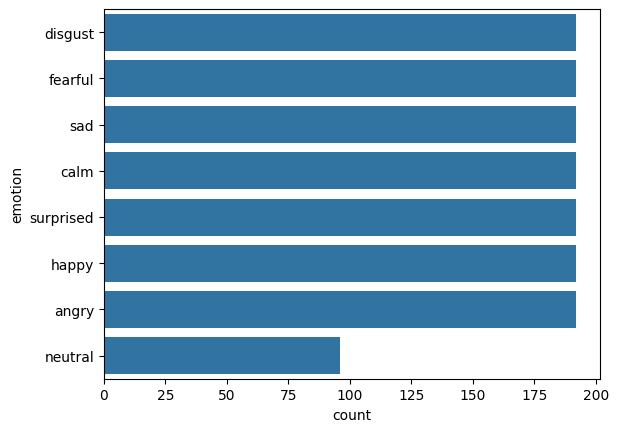

In [26]:
_ = sns.countplot(dataset_information['emotion']) # How many samples of each emotion are there

> Neutral emotion has half the samples since it does not have an intense expression, so some kind of dataset balancing is required

### Processing functions

In [27]:
def preprocess(data, cfg, original_sr):
    result = librosa.resample(data, orig_sr=original_sr, target_sr=cfg.sr)
    
    mask = []
    cutoff_value = 0.002 # To remove empty parts of the recordings

    result_abs = pd.Series(result).apply(np.abs)
    result_abs_mean = result_abs.rolling(window=int(cfg.sr / 10), min_periods=1, center=True).mean()
    
    for mean in result_abs_mean:
        if mean > cutoff_value:
            mask.append(True)
        else:
            mask.append(False)
    
    result = np.array(pd.Series(result)[mask])

    if len(result) < cfg.input_size: return None
    
    result = librosa.effects.preemphasis(result)    
    
    b, a = scipy.signal.butter(5, 25 / cfg.sr, 'high') # A highpass filter with 20Hz cutoff frequency 
    result = scipy.signal.filtfilt(b, a, result, method='gust', axis=0)
    
    return result

### Observing the data

In [28]:
unique_label_samples = dataset_information.drop_duplicates(subset=['gender', 'emotion', 'intensity'])
unique_label_samples.sample(2)

,filepath,gender,emotion,intensity
129,./dataset/Actor_16/03-01-05-02-02-02-16.wav,female,angry,strong
125,./dataset/Actor_16/03-01-02-01-02-01-16.wav,female,calm,normal


In [29]:
def make_plots(title, cfg, data):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    
    fig.suptitle(title)
    fig.set_size_inches(10, 2.5)
    
    ax[0].set(title='Time-ampitude')
    ax[1].set(title='Mel')
    ax[2].set(title='MFCC')

    feature_mel = librosa.feature.melspectrogram(y=data, sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    feature_mfcc = librosa.feature.mfcc(y=data, sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    
    time_amplitude = librosa.display.waveshow(y=data, sr=sr, ax=ax[0], color='purple', transpose = False) # Color is explicitly specified to avoid librosa's bug    
    mel = librosa.display.specshow(data=librosa.power_to_db(feature_mel), sr=cfg.sr, ax=ax[1], x_axis='time', y_axis='mel')
    mfcc = librosa.display.specshow(data=feature_mfcc, sr=sr, ax=ax[2], x_axis='time')

    fig.tight_layout()


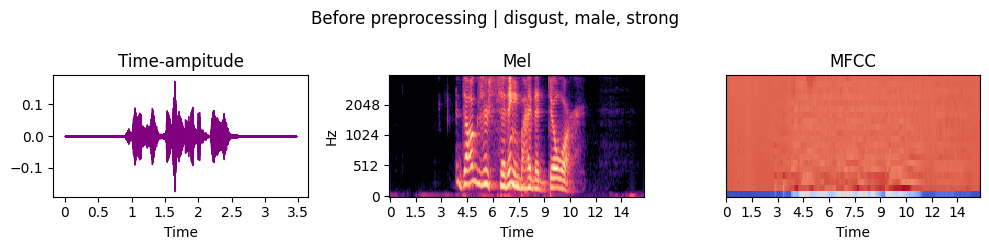

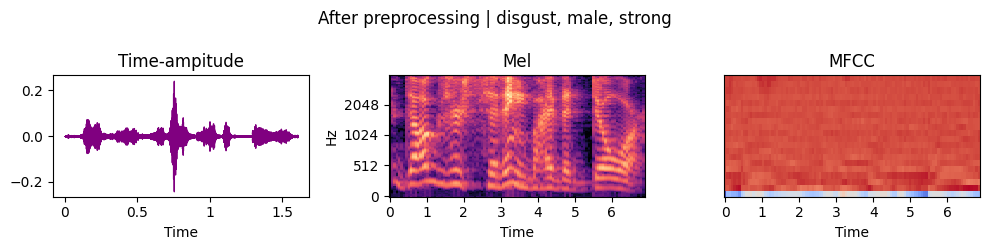

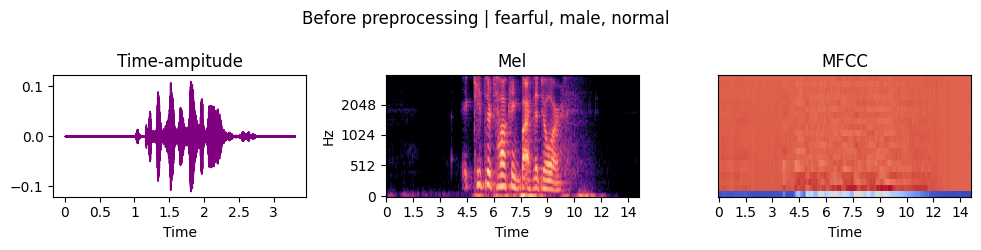

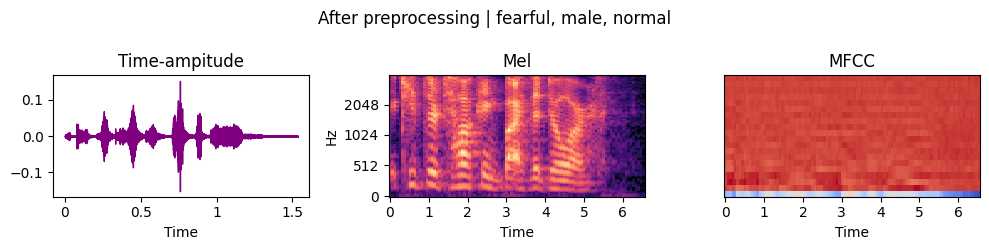

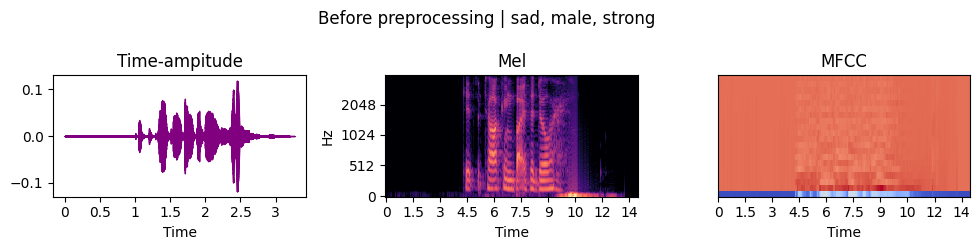

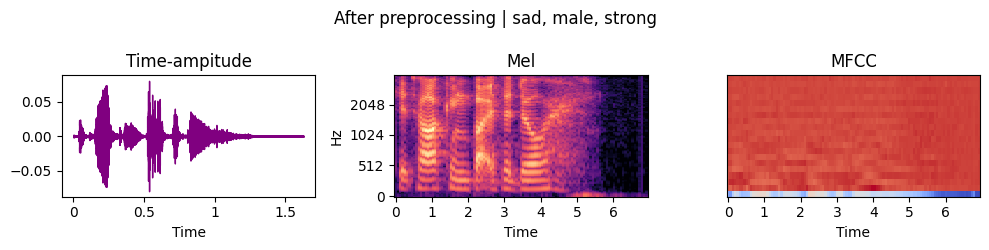

In [30]:
stop_after = 3

for index, sample in unique_label_samples.iterrows():
    stop_after -= 1
    if stop_after < 0: break

    data, sr = librosa.load(sample.filepath, sr=cfg.sr)
    make_plots(f'Before preprocessing | {sample.emotion}, {sample.gender}, {sample.intensity}', cfg, data)
    make_plots(f'After preprocessing | {sample.emotion}, {sample.gender}, {sample.intensity}', cfg, preprocess(data, cfg, cfg.sr))

In [31]:
listen_sample_data, _ = librosa.load(dataset_information.sample(1).iloc[0].filepath, sr=cfg.sr)

In [32]:
Audio(listen_sample_data, rate=cfg.sr) # Before preprocessing

In [33]:
Audio(preprocess(listen_sample_data, cfg, cfg.sr), rate=cfg.sr) # After preprocessing

### Class balancing

In [34]:
dataset_already_processed = len(os.listdir('processed')) != 0

In [35]:
class_distribution = pd.Series(index=STR_TO_EMOTION.values(), data=[0]*len(STR_TO_EMOTION.values()))

In [36]:
samples = dict(zip(STR_TO_EMOTION.values(), [[], [], [], [], [], [], [], []]))

In [37]:
if not dataset_already_processed:
    for _, sample in tqdm(dataset_information.iterrows(), total=dataset_information.shape[0], desc='Loading and preprocessing the dataset now'):
        data, sr = librosa.load(sample.filepath, sr=cfg.sr)
        data = preprocess(data, cfg, original_sr=cfg.sr)
        
        if data is not None:
            class_distribution[sample.emotion] += len(data)
            samples[sample.emotion].append(data)

In [38]:
if not dataset_already_processed:
    _ = plt.pie(class_distribution, labels=class_distribution.index, autopct='%.2f%%')

> To balance the classes out random sampling will be performed using inverse distribution. Different augmentations will be picked out at random, and more diverse augmentations are to be applied to less common labels across the preprocessed data.

In [39]:
rebalance_coefficients = class_distribution.max() / class_distribution
print(rebalance_coefficients)

neutral     NaN
calm        NaN
happy       NaN
sad         NaN
angry       NaN
fearful     NaN
disgust     NaN
surprised   NaN
dtype: float64


### Data Augmentation

> Impulse Responses from  https://mcdermottlab.mit.edu/Reverb/IR_Survey.html
> 
> Should be copied under the directory of `./research/impulse_responses`

In [40]:
augment = audiomentations.Compose([
    audiomentations.RepeatPart(mode='replace', p=1.0),
    audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=1.0),
    audiomentations.AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.001, p=1.0),
    audiomentations.AddColorNoise(p=1.0),
    audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=1.0),
])

In [41]:
Audio(augment(samples=np.array(samples['neutral'][0]), sample_rate=cfg.sr), rate=cfg.sr) # Augmentation playground

IndexError: list index out of range

In [ ]:
samples_per_class = 200

In [ ]:
if not dataset_already_processed:
    augmentation_failed = 0
    
    for emotion in samples:
        p_increase = rebalance_coefficients[emotion] / 10
        augment = audiomentations.Compose([
            audiomentations.RepeatPart(mode='replace', p=0.1 + (p_increase / 2)),
            audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=0.05 + (p_increase / 5)),
            audiomentations.AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.001, p=0.2),
            audiomentations.AddColorNoise(p=0.1 + (p_increase)),
            audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=0.3),
        ])
        
        for i in tqdm(range(samples_per_class), desc=emotion):
            random_index = np.random.randint(0, len(samples[emotion]))
            try:
                sf.write(f'processed/{emotion}_{i}.wav', augment(samples=np.array(samples[emotion][random_index]), sample_rate=cfg.sr), cfg.sr)
            except Exception as e:
                sf.write(f'processed/{emotion}_{i}.wav', np.array(samples[emotion][random_index]), cfg.sr)
                augmentation_failed += 1
                print(e)

    print(f'Augmentation failed {augmentation_failed} times during the whole process')

## Training the model (TODO)

In [42]:
X, Y = [], []

In [43]:
for file in tqdm(os.listdir('processed'), desc='Calculating the features'):
    if 'wav' not in file: continue
    data, sr = librosa.load('processed/' + file)
    for i in range(0, len(data) - cfg.input_size, cfg.input_size):
        feature_mfcc = librosa.feature.mfcc(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
        X.append(feature_mfcc)
        Y.append(file.split('_')[0])

Calculating the features:   0%|          | 0/1600 [00:00<?, ?it/s]

<Axes: xlabel='count'>

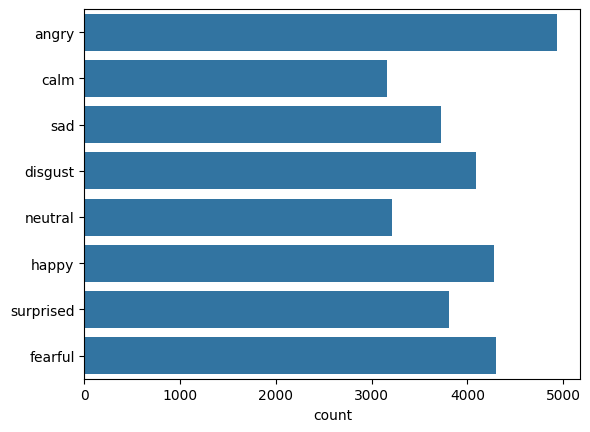

In [44]:
sns.countplot(Y)

> Still some imbalance in the data since different emotions tend to take up different amounts of time to express

In [45]:
classes = np.unique(Y)

In [46]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=classes, y=Y)

In [76]:
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [48]:
onehot_enc = tf.keras.utils.to_categorical([i for i in range(len(classes))])

In [49]:
onehot_map = {classes: encoding for classes, encoding in zip(classes, onehot_enc)}

In [50]:
print(onehot_map)

{'angry': array([1., 0., 0., 0., 0., 0., 0., 0.]), 'calm': array([0., 1., 0., 0., 0., 0., 0., 0.]), 'disgust': array([0., 0., 1., 0., 0., 0., 0., 0.]), 'fearful': array([0., 0., 0., 1., 0., 0., 0., 0.]), 'happy': array([0., 0., 0., 0., 1., 0., 0., 0.]), 'neutral': array([0., 0., 0., 0., 0., 1., 0., 0.]), 'sad': array([0., 0., 0., 0., 0., 0., 1., 0.]), 'surprised': array([0., 0., 0., 0., 0., 0., 0., 1.])}


In [51]:
for i in range(len(Y)):
    Y[i] = onehot_map[Y[i]]

In [52]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1) # 10% - test data size

In [53]:
X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.15) # 15% - validation data size

In [55]:
input_shape = np.array(X_train).shape
print(input_shape)

(24097, 20, 14)


In [96]:
with tf.device('/cpu:0'): # '/gpu:0' for GPU
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(20, 14, 1)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [97]:
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 20, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 7, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 7, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,147,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,248,456 (4.76 MB)

 Trainable params: 1,248,456 (4.76 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
    checkpoint = tf.keras.callbacks.ModelCheckpoint('models/emvoia.keras', monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False)

In [103]:
    model.fit(np.array(X_train), np.array(Y_train), epochs=10, batch_size=32, verbose=1, class_weight=class_weights, validation_split=0.1, callbacks=[checkpoint])
    model.save('models/emvoia.keras')

Epoch 1/10
677/678 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.1882 - loss: 2.0192
Epoch 1: val_acc improved from -inf to 0.22697, saving model to models/emvoia.keras
678/678 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - acc: 0.1883 - loss: 2.0191 - val_acc: 0.2270 - val_loss: 1.9553
Epoch 2/10
677/678 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.2377 - loss: 1.9311
Epoch 2: val_acc did not improve from 0.22697
678/678 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - acc: 0.2377 - loss: 1.9311 - val_acc: 0.2245 - val_loss: 1.9476
Epoch 3/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.2590 - loss: 1.8957
Epoch 3: val_acc improved from 0.22697 to 0.24938, saving model to models/emvoia.keras
678/678 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - acc: 0.2590 - loss: 1.8957 - val_acc: 0.2494 - val_loss: 1.9102
Epoch 4/10
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.2645 - loss: 1.8810
Epoch 4: val_acc improved from 0.24938 to 0.26141, saving model to models/emvoia.keras
678/678 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/ste

## Validation

## Test

In [116]:
def onehot_to_emotion(array):
    return list(onehot_map)[np.argmax(array)]

In [120]:
def predict(input):
    return onehot_to_emotion(model.predict(np.expand_dims(input, axis=0)))

In [132]:
    for i in range(len(X_test)):
        print(predict(X_test[i]), onehot_to_emotion(Y_test[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
neutral disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
fearful fearful
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
happy calm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
happy happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
sad angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
happy surprised
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
angry surprised
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
fearful happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
calm neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
neutral sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
fearful sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
happy fearful
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
disgust happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
angry surprised
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
fearful sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sad sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
happy neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
calm neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
neutral sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

KeyboardInterrupt: 